# 🔍 Predicting Item Prices from Descriptions (Part 4)

https://github.com/lisek75/nlp_llms_notebook/blob/main/09_part4_ft_gpt4omini.ipynb

---
-  Data Curation & Preprocessing
- Model Benchmarking – Traditional ML vs LLMs
- E5 Embeddings & RAG
- ➡️ Fine-Tuning GPT-4o Mini
- Evaluating LLaMA 3.1 8B Quantized
- Fine-Tuning LLaMA 3.1 with QLoRA
- Evaluating Fine-Tuned LLaMA
- Summary & Leaderboard

---

# 🔧 Part 4: Fine-Tuning GPT-4o Mini

- 🧑‍💻 Skill Level: Advanced
- ⚙️ Hardware: ✅ CPU is sufficient — no GPU required
- 🛠️ Requirements: 🔑 HF Token, Open API Key, wandb API Key
- Tasks:
    - Convert chat data to .jsonl format for OpenAI
    - Fine-tune the model and monitor with Weights & Biases
    - Test the fine-tuned GPT-4o Mini 

Can fine-tuning GPT-4o Mini outperform both its zero-shot baseline and RAG-enhanced version?  
Time to find out.

In [1]:
# imports

import os, importlib, json, re
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset
from openai import OpenAI

In [40]:
load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key: print("❌ OPENAI_API_KEY is missing")
    
openai = OpenAI(api_key=openai_api_key)

hf_token = os.getenv('HF_TOKEN')
if not hf_token: print("❌ HF_TOKEN is missing")
    
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# 📥 Load Dataset

In [3]:
HF_USER = "Lizk75"
DATASET_NAME = f"{HF_USER}/pricer-data"

dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [4]:
test[0]

{'text': 'How much does this cost to the nearest dollar?\n\nSolera Slide Topper Slide-Out Protection for RVs, Travel Trailers, 5th Wheels, and Motorhomes\nTired of dirt, leaves and bird droppings piling up on your slide-out? Solera® Slide Toppers are an economical, attractive way for you to help protect your RV’s slide-out from debris and water infiltration. Compatible with leading slide-out brands on the market today, our Slide Topper awnings automatically extend and retract, right along with your slide-out — giving you automatic protection, every time.Our heavy-duty, 13.5 oz. Slide Topper vinyl is constructed with heat-welded, leak-resistant seams to prevent water infiltrations and seam damage — plus, it’s designed to withstand -25 degrees Fahrenheit, so it won’t crack in\n\nPrice is $',
 'price': 368.43}

# 🛠️ Step 1 : Data Preparation

To fine-tune GPT-4o-mini, OpenAI requires training data in **.jsonl format**. 

`make_jsonl` converts our chat data :

from 

[
  {"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"},
  {"role": "user", "content": "How much is this laptop worth?"},
  {"role": "assistant", "content": "Price is $999.00"}
]

into the .jsonl format 

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much is this laptop worth?"}, {"role": "assistant", "content": "Price is $999.00"}]}


In [5]:
# Mask the price in the test item
def mask_price_value(text):
    return re.sub(r"(\n\nPrice is \$).*", r"\1", text)

In [6]:
def messages_for(datapoint):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = mask_price_value(datapoint["text"]).replace(" to the nearest dollar", "").replace("\n\nPrice is $","")
    assistant_response = f"Price is ${datapoint['price']:.2f}"
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": assistant_response}
    ]

messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nDetail King TNT Tire Gel - Vibrant Car Tire Shine - Tire Dressing and Trim Shine - Gallon\nThe TNT Tire Gel is a water-based, silicone gel dressing that gives tires a bright, glossy finish. Easy to apply and durable, this gel is a remarkable product for both auto detailers and car enthusiasts looking to achieve a quick shine on their tires. For Best Results Apply to clean tires. Squeeze a few lines of product onto an Automotive Tire Dressing Applicator. Thoroughly rub into the grooves of your tires. Scrub both horizontally and vertically to reach all crevices. Allow the gel to set into the tires for a half hour before driving. This helps to avoid sling. You’re done! Just a little bit of gel and your tires look brand new'},
 {'role': 'assistant', 'content': 'Price is $129.95'}]

In [27]:
def make_jsonl(datapoints):
    result = ""
    for datapoint in datapoints:
        messages = messages_for(datapoint)
        messages_str = json.dumps(messages, ensure_ascii=False)
        result += '{"messages": ' + messages_str + '}\n'
    return result.strip()

make_jsonl(train.select([0]))

'{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\\n\\nDetail King TNT Tire Gel - Vibrant Car Tire Shine - Tire Dressing and Trim Shine - Gallon\\nThe TNT Tire Gel is a water-based, silicone gel dressing that gives tires a bright, glossy finish. Easy to apply and durable, this gel is a remarkable product for both auto detailers and car enthusiasts looking to achieve a quick shine on their tires. For Best Results Apply to clean tires. Squeeze a few lines of product onto an Automotive Tire Dressing Applicator. Thoroughly rub into the grooves of your tires. Scrub both horizontally and vertically to reach all crevices. Allow the gel to set into the tires for a half hour before driving. This helps to avoid sling. You’re done! Just a little bit of gel and your tires look brand new"}, {"role": "assistant", "content": "Price is $129.95"}]}'

In [8]:
ft_train = train.select(range(100))
ft_validation = train.select(range(100, 150))

In [9]:
# Convert the items into jsonl and write them to a file

def write_jsonl(datapoints, filename):
    with open(filename, "w", encoding="utf-8") as f:
        jsonl = make_jsonl(datapoints)
        f.write(jsonl)

In [10]:
write_jsonl(ft_train, "data/ft_train.jsonl")
write_jsonl(ft_validation, "data/ft_val.jsonl")

In [11]:
with open("data/ft_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")
with open("data/ft_val.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [12]:
train_file

FileObject(id='file-63LxeJyTAWxa5k1yeKxsVg', bytes=94452, created_at=1744225393, filename='ft_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [13]:
validation_file

FileObject(id='file-PsWP33S3y4W3LKJiqtZadH', bytes=47431, created_at=1744225394, filename='ft_val.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

# 🚀 Step 2: Run Fine-Tuning & Monitor with wandb
We will use https://wandb.ai to monitor the training runs

1- Create an API key in wandb

2- Add this key in OpenAI dashboard https://platform.openai.com/account/organization

In [14]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [15]:
# Run the fine tuning

openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-z90Zqr6Wnh68xAZ6hkL5rvMi', created_at=1744225397, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-AalSWqvkkoOsbtYdAVNBKdjL', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-63LxeJyTAWxa5k1yeKxsVg', validation_file='file-PsWP33S3y4W3LKJiqtZadH', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-z90Zqr6Wnh68xAZ6hkL5rvMi'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [23]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id
job_id

# Then check your wandb dashboard to view the run of this job ID

'ftjob-z90Zqr6Wnh68xAZ6hkL5rvMi'

In [36]:
# Use this command to track the fine-tuning progress here

openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=2).data

[FineTuningJobEvent(id='ftevent-uxEiQLW3Zfj71Zlrdk6Jobqm', created_at=1744226247, level='info', message='Step 100/100: training loss=1.57, validation loss=1.35, full validation loss=1.06', object='fine_tuning.job.event', data={'step': 100, 'train_loss': 1.5733776092529297, 'valid_loss': 1.3517630100250244, 'total_steps': 100, 'full_valid_loss': 1.0632328414916992, 'train_mean_token_accuracy': 0.75, 'valid_mean_token_accuracy': 0.75, 'full_valid_mean_token_accuracy': 0.7925}, type='metrics'),
 FineTuningJobEvent(id='ftevent-nJHA9OA3N0fZZH50XHcZpD9U', created_at=1744226236, level='info', message='Step 99/100: training loss=0.78, validation loss=1.53', object='fine_tuning.job.event', data={'step': 99, 'train_loss': 0.7829427719116211, 'valid_loss': 1.5319545269012451, 'total_steps': 100, 'train_mean_token_accuracy': 0.875, 'valid_mean_token_accuracy': 0.75}, type='metrics')]

# 📧 You’ll get an email once fine-tuning is complete. ☕ You can take a break until then. ▶️ Once you receive it, run the cells below to continue.

## Step 3 : Test the fine tuned model

In [42]:
ft_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
ft_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:BKVDmiKN'

In [43]:
# Build LLM messages
def build_messages(datapoint):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = mask_price_value(datapoint["text"]).replace(" to the nearest dollar", "").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

def gpt_ft(datapoint):
    response = openai.chat.completions.create(
        model=ft_model_name, 
        messages=build_messages(datapoint),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [44]:
print(test[0]["price"])
print(gpt_ft(test[0]))

368.43
154.65


🔔 **Reminder:**  
- In **Part 2**, GPT-4o Mini (zero-shot) scored:  
  Avg. Error: ~$99 | RMSLE: 0.75 | Accuracy: 44.8%  

- In **Part 3**, with **RAG**, performance improved to:  
  Avg. Error: ~$59.54 | RMSLE: 0.42 | Accuracy: 69.2%

🧪 **Now it’s time to see** if fine-tuning can push GPT-4o Mini even further and outperform both baselines.

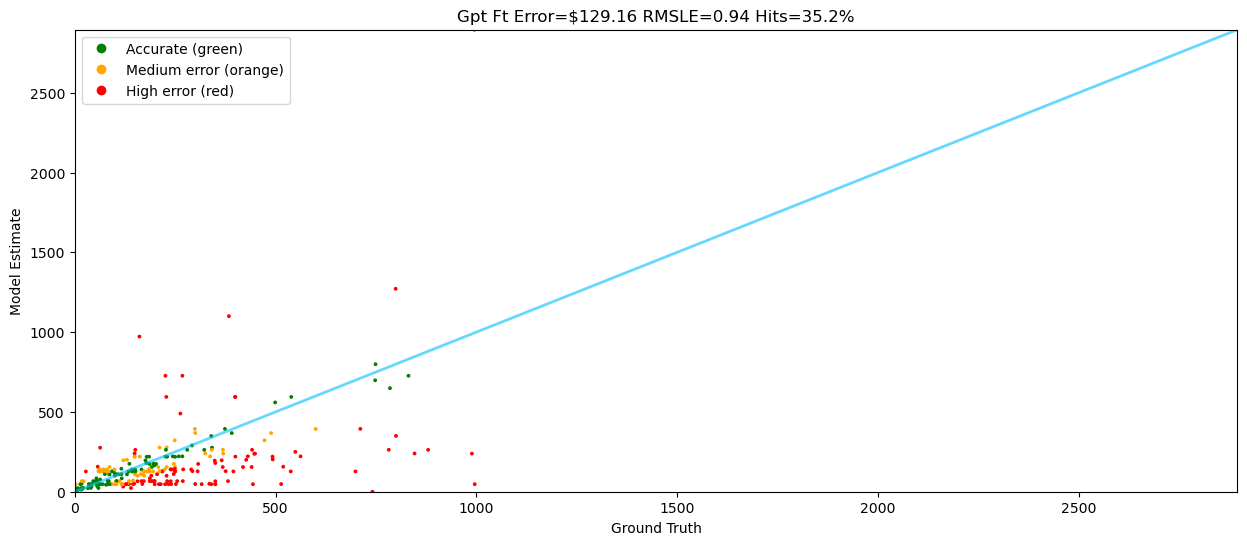

In [46]:
import helpers.testing
importlib.reload(helpers.testing)

from helpers.testing import Tester

tester = Tester(gpt_ft, test)
tester.run()

**Fine-tuning GPT-4o Mini led to worse performance than both its zero-shot and RAG-enhanced versions.**

⚠️ When Fine-Tuning Isn’t Needed:
- For tasks like price prediction, GPT-4o performs well with prompting alone — thanks to strong pretraining and generalization.
- 💡 Fine-tuning isn’t always better. Use it when prompting fails — not by default.

✅ **When Fine-Tuning Is Worth It (based on OpenAI’s own guidelines)**
- Custom tone/style – e.g., mimicking a brand voice or writing like a specific author
- More consistent output – e.g., always following a strict format
- Fix prompt failures – e.g., when multi-step instructions get ignored
- Handle edge cases – e.g., rare product types or weird inputs
- Teach new tasks – e.g., estimating prices in a custom format no model has seen before

---

Now that we’ve explored both frontier closed-source models and traditional ML, it’s time to turn to open-source.

🚀 **Next up: Fine-tuned LLaMA 3.1 8B (quantized)** — can it beat its base version, outperform GPT-4o Mini, or even challenge the big players?

🔍 Let’s find out in the next notebook. https://github.com/lisek75/nlp_llms_notebook/blob/main/09_part5_llama31_8b_quant.ipynb